In [13]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  
from sklearn.decomposition import PCA
import umap
import math
import io
import umap.plot
import plotly.graph_objs as go 
import plotly.io as pio 
pio.renderers.default ='iframe'


from collections import defaultdict
from tqdm import tqdm
import wandb
import random
from PIL import Image  # Add this import statement


from collections import defaultdict

import math,os,sys
import warnings 
warnings.filterwarnings('ignore')

In [14]:
from mnist_dataset import MNISTDataset 
#load dataset 
data = pd.read_csv('../data/train.csv')
data = data[:10000]
#temporarly trying to overfit with less data
val_count = 3000

#common transformation
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

#split the train to val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 3982.16it/s]


In [15]:
#setup Dataloaders with pytorch dataloaders
trainloader = DataLoader(
    dataset,
    batch_size = 128*4,
    shuffle =True,
    #pin_memory = True, # for faster data transfer speed btn CPU and GPU, but will consume more system memory
    num_workers = 2,
    #prefetch_factor = 100,#to specify how many batches should be prefetched(loaded into memory[increased memory usage tho]) asynchronously in advance.

) 

# visualizing Datapoints

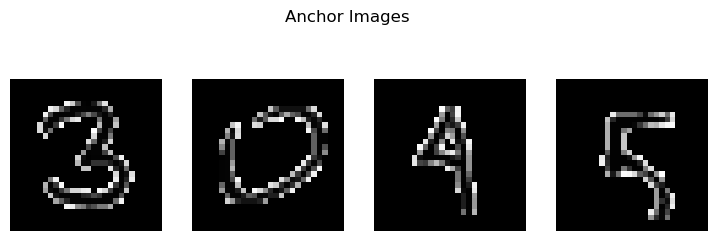

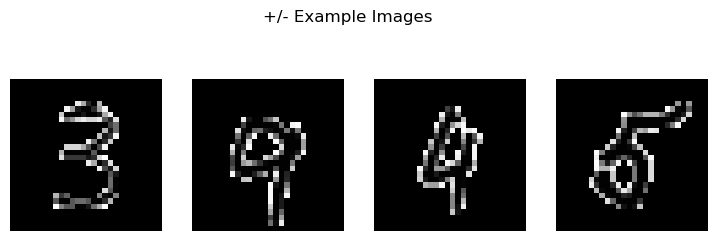

In [16]:
def show_images(images, title =''):
    num_images = len(images)
    fig,axes = plt.subplots(1, num_images,figsize=(9,3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img,cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()
    
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainloader):
    #converting tensors to numpy, numpy is easy to muniplate and display with matplotlib
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()

    #display some imgages from batch
    show_images(anchor_images[:4], title = 'Anchor Images')
    show_images(contrastive_images[:4], title = '+/- Example Images')
    #break after displaying from one batch for demostration 
    break

# lets build Neural Network
-  Define a neural network architecture with two convolution layers and two fully connected layers
- Input to the network is an MNIST image and Output is a 64 dimensional representation. 


In [17]:
from Network import Network,Network_t ,ContrastiveLoss_with_margin
from utils import init_weights, init_weights_for_gelu

In [18]:
net = Network()

device= "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device= "mps"

#device= "cpu" #overide device for overfitting a very small data batch
net = net.to(device)

device

'mps'

### weight initialization 

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingLR

In [20]:
epoch_count=10
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01,weight_decay=1e-5)
#optimizer = torch.optim.AdamW(net.parameters())
loss_function = ContrastiveLoss_with_margin()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)
scheduler = CosineAnnealingLR(optimizer, T_max=epoch_count, eta_min=1e-6)
#scheduler reduces plateau loss
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


In [21]:
import os
checkpoint_dir ='checkpoints/'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

## Testing the state of the model defination of it works for simple digit recognition

# take two

wandb: Currently logged in as: merhawi (ajax_m). Use `wandb login --relogin` to force relogin


epoch- 0
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:15<00:00,  1.07s/it]


epoch_loss 0.19701569420950754
epoch- 1
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.96it/s]


epoch_loss 0.19762413842337473
epoch- 2
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.07it/s]


epoch_loss 0.19709067685263498
epoch- 3
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.14it/s]


epoch_loss 0.19715166091918945
epoch- 4
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.04it/s]


epoch_loss 0.19643969195229666
epoch- 5
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]


epoch_loss 0.19492197036743164
epoch- 6
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.69it/s]


epoch_loss 0.19539053099496023
epoch- 7
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]


epoch_loss 0.19511204106467112
epoch- 8
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]


epoch_loss 0.19525871958051408
epoch- 9
learning rate 0.01


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.03it/s]


epoch_loss 0.19477507046290807
Plotting data for layer: conv1.2
Means: [[0.3434281647205353, 0.34449729323387146, 0.3440406024456024, 0.34422767162323, 0.3442836105823517, 0.3441384732723236, 0.3436742424964905, 0.34337297081947327, 0.3443637788295746, 0.3443378210067749, 0.3457982540130615, 0.34473803639411926, 0.3443097770214081, 0.3443300426006317], [0.34481140971183777, 0.34301483631134033, 0.34487926959991455, 0.3446313142776489, 0.34486275911331177, 0.34582534432411194, 0.34338027238845825, 0.34391212463378906, 0.34465110301971436, 0.344030499458313, 0.3432873487472534, 0.3449694514274597, 0.34512874484062195, 0.3437228798866272], [0.3446332812309265, 0.3456582725048065, 0.3447592258453369, 0.34418150782585144, 0.3439684510231018, 0.3433457016944885, 0.3435926139354706, 0.3445025086402893, 0.34413960576057434, 0.34442082047462463, 0.3454948961734772, 0.34528958797454834, 0.34514686465263367, 0.34399768710136414], [0.3436705768108368, 0.34325534105300903, 0.3450087904930115, 0.344

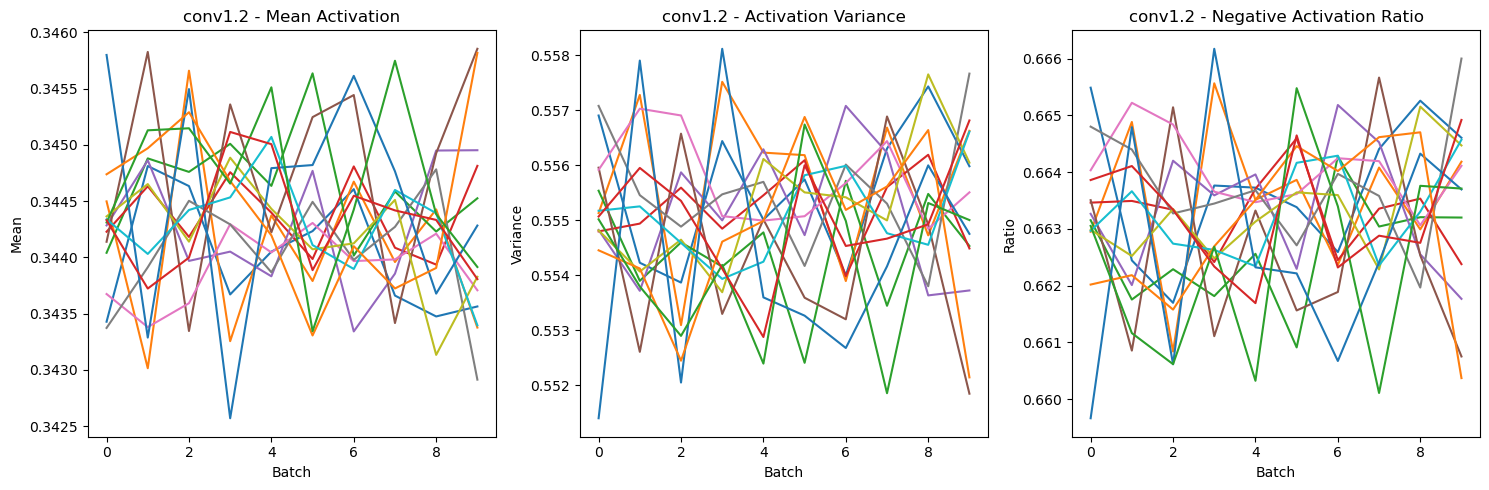

Plotting data for layer: conv2.2
Means: [[0.3449086546897888, 0.3452664613723755, 0.3451569080352783, 0.34580034017562866, 0.3453412652015686, 0.345232754945755, 0.34465673565864563, 0.3440884053707123, 0.3452741503715515, 0.3456862270832062, 0.3472749590873718, 0.34558412432670593, 0.34622257947921753, 0.3445776104927063], [0.3459349274635315, 0.34454959630966187, 0.3455469608306885, 0.3460270166397095, 0.34609004855155945, 0.3466130495071411, 0.3449121415615082, 0.3445156514644623, 0.346005380153656, 0.34523648023605347, 0.3448438048362732, 0.3459185063838959, 0.3462395668029785, 0.34490320086479187], [0.3457438349723816, 0.3467629849910736, 0.3459464907646179, 0.34538713097572327, 0.3455353379249573, 0.3444267213344574, 0.3448061943054199, 0.3453586995601654, 0.345182865858078, 0.345962256193161, 0.34631142020225525, 0.3466048538684845, 0.3456459939479828, 0.3448670506477356], [0.34559255838394165, 0.3438541889190674, 0.3459492027759552, 0.34583866596221924, 0.34561142325401306, 0.3

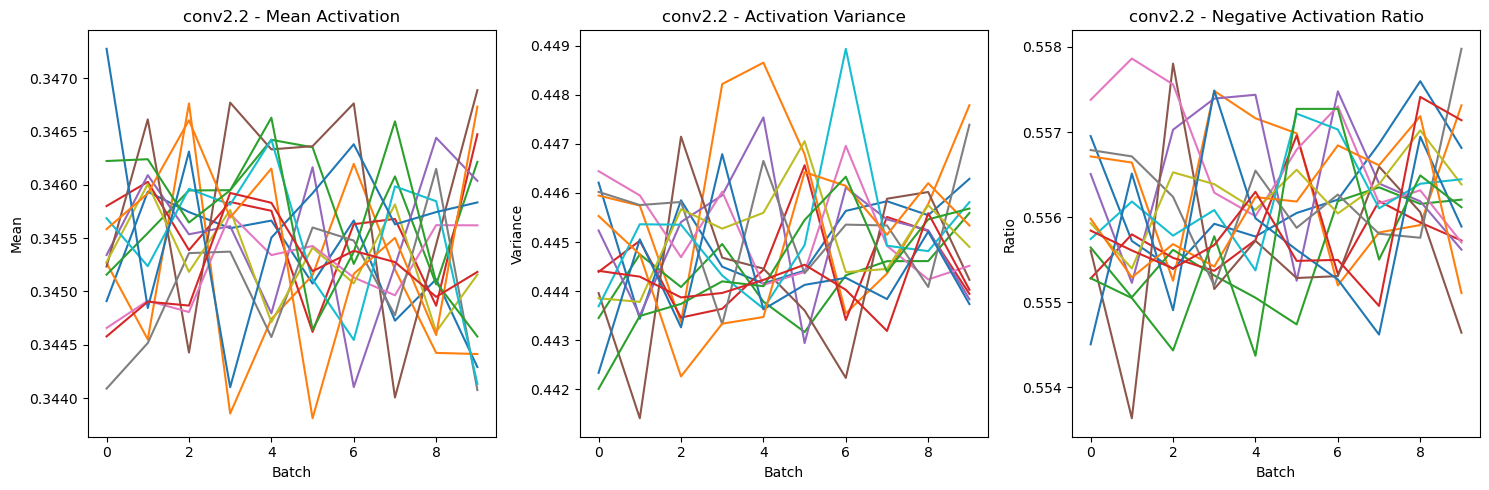

Plotting data for layer: conv3.2
Means: [[0.3416339159011841, 0.3408015966415405, 0.3414292335510254, 0.3418729901313782, 0.3415795564651489, 0.3420566916465759, 0.34167420864105225, 0.34020140767097473, 0.341913640499115, 0.34235650300979614, 0.34290552139282227, 0.3414817154407501, 0.34408852458000183, 0.3404490351676941], [0.34175679087638855, 0.34060657024383545, 0.3408702611923218, 0.3420424461364746, 0.34235939383506775, 0.34245002269744873, 0.34131374955177307, 0.3410415053367615, 0.3426814377307892, 0.34192270040512085, 0.3410745859146118, 0.3423042893409729, 0.342094361782074, 0.34112969040870667], [0.34159642457962036, 0.3427945077419281, 0.34211498498916626, 0.34208667278289795, 0.3413519561290741, 0.3406449854373932, 0.34096789360046387, 0.3403339684009552, 0.3409274220466614, 0.3417818546295166, 0.3428581953048706, 0.342283695936203, 0.341860294342041, 0.34015312790870667], [0.3416268229484558, 0.33993005752563477, 0.34159350395202637, 0.3422185182571411, 0.341797053813934

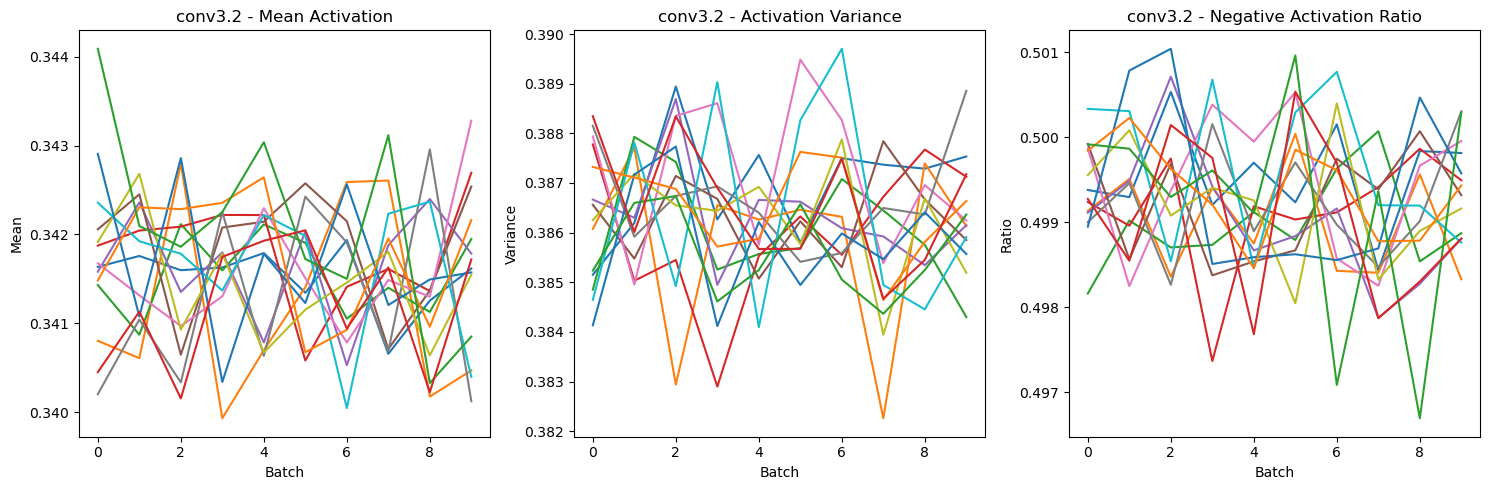

Plotting data for layer: conv4.2
Means: [[0.3707420229911804, 0.37117546796798706, 0.3707374334335327, 0.3707128167152405, 0.37118610739707947, 0.372907429933548, 0.3705887198448181, 0.3701750636100769, 0.37001901865005493, 0.37155991792678833, 0.3723255395889282, 0.36980825662612915, 0.3730143904685974, 0.37051552534103394], [0.37183916568756104, 0.37108558416366577, 0.37004372477531433, 0.3712974786758423, 0.37167665362358093, 0.3719714283943176, 0.37131762504577637, 0.3694766163825989, 0.37139198184013367, 0.3703872561454773, 0.37000101804733276, 0.37082183361053467, 0.37074822187423706, 0.37022730708122253], [0.3697242736816406, 0.37108707427978516, 0.3717859387397766, 0.3716312348842621, 0.3694508373737335, 0.3699225187301636, 0.3700251579284668, 0.37110474705696106, 0.37145256996154785, 0.3708784580230713, 0.3707349896430969, 0.3707377314567566, 0.3703884184360504, 0.3711179792881012], [0.37198954820632935, 0.3703343868255615, 0.37229520082473755, 0.3711772561073303, 0.3710893988

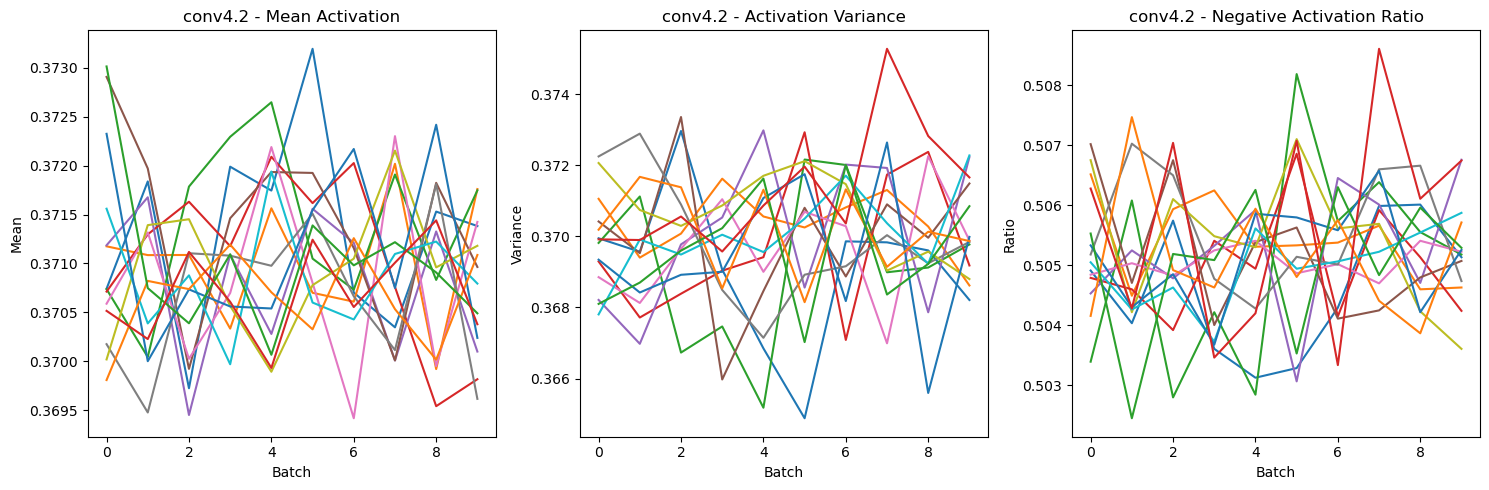

Plotting data for layer: linear1.1
Means: [[0.3458886444568634, 0.34458327293395996, 0.34666940569877625, 0.34444737434387207, 0.347080796957016, 0.3472626805305481, 0.34560227394104004, 0.3431578278541565, 0.3450733423233032, 0.3442218601703644, 0.34743374586105347, 0.3449438810348511, 0.34389761090278625, 0.34411653876304626], [0.34765443205833435, 0.34472423791885376, 0.3461231589317322, 0.34504199028015137, 0.3430124521255493, 0.34667155146598816, 0.34715867042541504, 0.34305810928344727, 0.34490513801574707, 0.3434121012687683, 0.345442533493042, 0.3468555510044098, 0.34546902775764465, 0.3448427617549896], [0.346993088722229, 0.3472447991371155, 0.34666505455970764, 0.34582334756851196, 0.34380584955215454, 0.34709084033966064, 0.34833112359046936, 0.3476196527481079, 0.3452856242656708, 0.3452652096748352, 0.34592530131340027, 0.3460010588169098, 0.344743013381958, 0.34371882677078247], [0.3451562225818634, 0.34460198879241943, 0.3470364511013031, 0.34621572494506836, 0.34474185

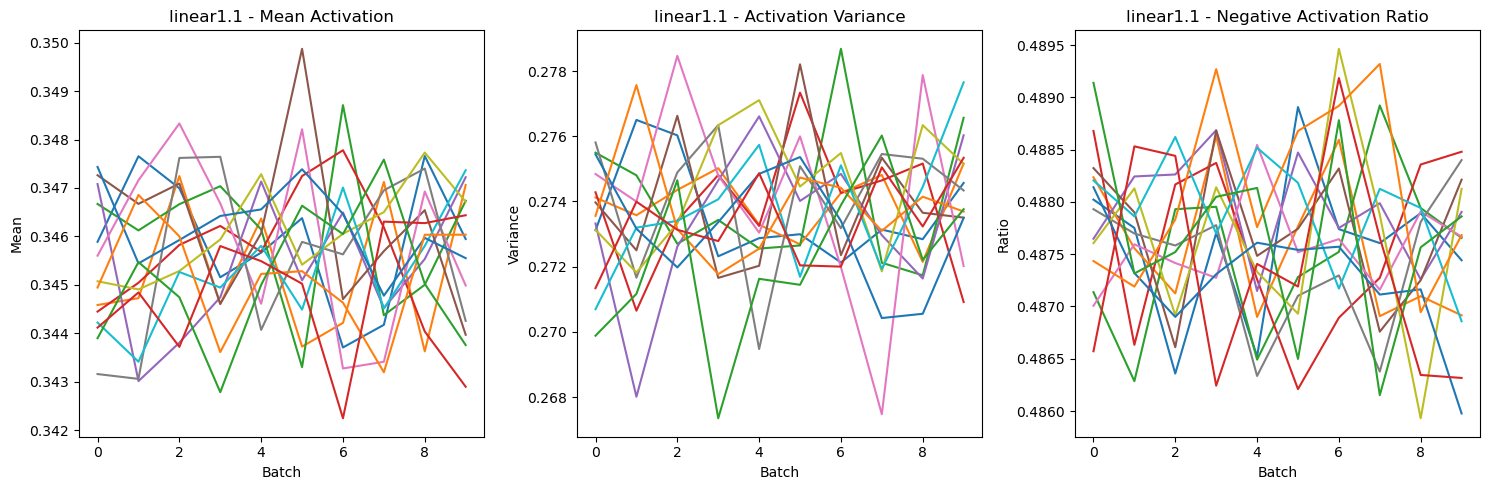

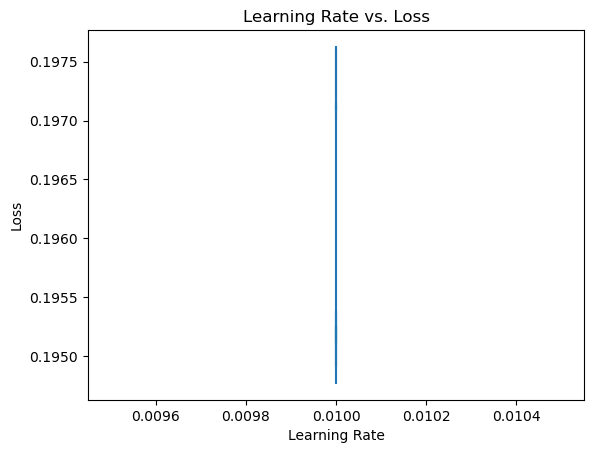

epoch,▁▂▃▃▄▅▆▆▇█
epoch_loss -,▇█▇▇▅▁▃▂▂▁
learning rate -,▁▁▁▁▁▁▁▁▁▁
Plotting data for layer,linear1.1
epoch,9
epoch_loss -,0.19478
learning rate -,0.01


<Figure size 640x480 with 0 Axes>

In [23]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Contrastive_learning",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "CNN with contrastive Loss",
    "dataset": "Mnist -dataset",
    "epochs": 10,
    "batch size" : 256,
    }
)

activations_list = []
gradients = []

def Train_model(epoch_count=10):
    net = Network()
    #The log="all" parameter tells wandb to log gradients and parameters, and 
    #log_freq=64 means it will log every 64 batches.
    wandb.watch(net, log="all", log_freq=64) 
    net.apply(init_weights_for_gelu)
    net = net.to(device)
    lrs = []
    losses = []
    activations_dict = defaultdict(lambda: {'mean': [], 'var': [], 'neg_ratio': []})
    
    def get_activation_stats(name):
        def hook(model, input, output):
            mean = output.detach().mean().item()
            var = output.detach().var().item()
            neg_ratio = (output.detach() < 0).float().mean().item()
            activations_dict[name]['mean'].append(mean)
            activations_dict[name]['var'].append(var)
            activations_dict[name]['neg_ratio'].append(neg_ratio)
            # this was not printing coz of leakyReLU wasnt correctly called(was only nn.ReLU)
            #print(f'Hook called for {name}: mean={mean}, var={var}, neg_ratio={neg_ratio}')
        return hook   
    
    # Register hooks for GELU layers (or whatever activation you're using)
    for name, layer in net.named_modules():
        if isinstance(layer, nn.LeakyReLU):
            layer.register_forward_hook(get_activation_stats(name))
            #print(f'Registered hook for layer: {name}') #-----debugging print worked
            
    def capture_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients.append((name, grad_output[0].detach()))
        return hook
        
    for epoch in range(epoch_count):
        epoch_loss = 0
        batches = 0
        
        print('epoch-', epoch) 
        wandb.log({'epoch': epoch})

        for param_group in optimizer.param_groups:
            lrs.append(param_group['lr'])
        
        print('learning rate', lrs[-1])
        wandb.log({'learning rate -':lrs[-1]})
        
        for anchor, contrastive, distance, label in tqdm(trainloader):
            # assert anchor.shape[1] == 1, f"Expected anchor channels to be 1, but got {anchor.shape[1]}"
            # assert contrastive.shape[1] == 1, f"Expected contrastive channels to be 1, but got {contrastive.shape[1]}"
            batches += 1
            optimizer.zero_grad()
            anchor_out = anchor.to(device, dtype=torch.float32)
            contrastive_out = contrastive.to(device, dtype=torch.float32)
            distance = distance.to(torch.float32).to(device)
            anchor_out = net(anchor_out)
            contrastive_out = net(contrastive_out)
            
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
        
        #avg_loss = epoch_loss / batches
        
        # Debugging: Print activation statistics
        #print(f'Activations after epoch {epoch}:', {k: {stat: v[stat][-batches:] for stat in v} for k, v in activations_dict.items()})
        
        activations_list.append({k: {stat: v[stat][-batches:] for stat in v} for k, v in activations_dict.items()})
        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        
        print('epoch_loss', losses[-1])
        wandb.log({'epoch_loss -': losses[-1]})
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    # Debugging: Print entire activations list
    #print('Final activations_list:', activations_list)

    plot_activation_stats(activations_list)

    plt.figure()
    plt.plot(losses, lrs)
    plt.ylabel('Learning Rate')
    plt.xlabel('Loss')
    plt.title('Learning Rate vs. Loss')
    plt.show()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # Convert BytesIO to PIL Image
    image1 = Image.open(buf)
    wandb.log({"Learning Rate vs. Loss": wandb.Image(image1)})

    return {
        "net": net,
        "losses": losses,
        "activations": activations_list
    }

def plot_activation_stats(activations_list):
    if not activations_list:
        print("No activation data to plot.")
        wandb.log({'message':'No activation data to plot'})
        return

    for layer_name in activations_list[0].keys():
        means = [epoch[layer_name]['mean'] for epoch in activations_list]
        vars = [epoch[layer_name]['var'] for epoch in activations_list]
        neg_ratios = [epoch[layer_name]['neg_ratio'] for epoch in activations_list]

        # logging this stat only on wandb 
        print(f'Plotting data for layer: {layer_name}')
        wandb.log({'Plotting data for layer':layer_name}) # logging this stat only on wandb 
        print(f'Means: {means}')
        wandb.log({'Means': means})
        print(f'Variances: {vars}')
        wandb.log({'Variances': vars})
        print(f'Negative Ratios: {neg_ratios}')
        wandb.log({'Negative Ratios':neg_ratios})

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.plot(means)
        plt.title(f'{layer_name} - Mean Activation')
        plt.xlabel('Batch')
        plt.ylabel('Mean')
        
        plt.subplot(132)
        plt.plot(vars)
        plt.title(f'{layer_name} - Activation Variance')
        plt.xlabel('Batch')
        plt.ylabel('Variance')

        plt.subplot(133)
        plt.plot(neg_ratios)
        plt.title(f'{layer_name} - Negative Activation Ratio')
        plt.xlabel('Batch')
        plt.ylabel('Ratio')
         
        plt.tight_layout()
        

        # Save the plot to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)

        # Convert BytesIO to PIL Image
        image = Image.open(buf)

        # Log the plot to Weights and Biases
        wandb.log({f'{layer_name} activations': wandb.Image(image)})
        plt.show() # this should be after wandb log 

        plt.close()  # Close the figure to free up memory
        buf.close()


# Example usage:
# Train_model(epoch_count=10)
checkpoint_dir = 'checkpoints'
train =True

if train:
    training_result = Train_model()
    model = training_result["net"]
else:
    model = load_latest_checkpoint(checkpoint_dir)
wandb.finish()

In [ ]:
#this prints the class layers modules 
def print_layer_types(net):
    for name, layer in net.named_modules():
        print(f'{name}: {type(layer)}')

# Example usage:
net = Network()
print_layer_types(net)


## experimaental model with simple image classification to check model health

In [ ]:
model = Network().to(device)

#torch compile
m = torch.compile(model)

#wandb watch
wandb.watch(m)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr= 00.0001)
lossi = []
for iter in range(max_iters): 
    if iter % eval_iterval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
        #wandb log
        wandb.log({"steps": iter,"train_loss": losses["train"], "val_loss": losses["val"]})

    xb,yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    lr =  lr if max_iters > 20000 else lr*10    #step learing rate Decay 
    optimizer.step()


# Visualize activations after training

## Debugging sessions

# initial loss estimation 

In [ ]:
margin = 0.5

# Expected loss for similar pairs
expected_similar_loss = 1.0  # As (1 - score)^2 with score ≈ 0

# Expected loss for dissimilar pairs
expected_dissimilar_loss = margin ** 2  # As (score - margin)^2 with score ≈ 0

# Average the losses
initial_loss = (expected_similar_loss + expected_dissimilar_loss) / 2

print(f'Expected initial contrastive loss (cosine similarity with margin): {initial_loss}')

#--- "Expected initial contrastive loss (cosine similarity with margin): 0.625"

In [ ]:
if training_result["activations"]:
    print(list(training_result["activations"][0].keys()))
    for key in training_result["activations"][0].keys():
        print(f"{key}: {training_result['activations'][0][key].keys()}")
else:
    print("Activations list is empty")

In [ ]:
def plot_activation_stats(activations_list):
    print(f"Number of epochs: {len(activations_list)}")
    
    if not activations_list:
        print("Activations list is empty")
        return

    for layer_name in activations_list[0].keys():
        print(f"Plotting for layer: {layer_name}")
        plt.figure(figsize=(15, 5))
        
        for i, stat in enumerate(['mean', 'var', 'neg_ratio'], 1):
            plt.subplot(1, 3, i)
            values = [epoch[layer_name][stat] for epoch in activations_list]
            print(f"{stat} values: {values[:5]}...")  # Print first 5 values
            
            if not values:
                print(f"No {stat} values for {layer_name}")
                continue
            
            plt.plot(values)
            plt.title(f'{layer_name} - {stat.capitalize()}')
            plt.xlabel('Batch')
            plt.ylabel(stat.capitalize())
        
        plt.tight_layout()
        plt.show()

plot_activation_stats(training_result["activations"])

In [ ]:
plt.figure(figsize=(20, 4))
legends = []

# Assuming activations_list is a list of dictionaries
for epoch, epoch_activations in enumerate(activations_list):
    print(activations_list)
    for i, (name, tensors) in enumerate(epoch_activations.items()):
        # Combine all tensors for this layer across batches
        all_tensors = torch.cat(tensors, dim=0)

        # Calculate metrics
        zero_percentage = (all_tensors == 0).float().mean().item() * 100
        mean_value = all_tensors.mean().item()
        std_value = all_tensors.std().item()
        sparsity = (all_tensors != 0).float().mean().item() * 100
        variance = all_tensors.var().item()
    
        print(f'Epoch {epoch}, Layer {i} ({name}): mean: {mean_value:+.2f}, std: {std_value:.2f}, zeros: {zero_percentage:.2f}%, sparsity: {sparsity:.2f}%, variance: {variance:.2f}')
     
        # Compute the histogram using numpy
        hist, bin_edges = np.histogram(all_tensors.cpu().numpy().flatten(), bins=50, range=(-2, 2))
        
        # Plot the histogram
        plt.plot(bin_edges[:-1], hist)
        legends.append(f'{name} (Epoch {epoch})')

plt.legend(legends)
plt.title('Activation Distributions')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Assuming 'activations' is a list of (name, tensor) tuples

plt.figure(figsize=(20, 4))
legends = []
for name, t in activations:
    # Calculate metrics
    zero_percentage = (t == 0).float().mean() * 100
    mean_value = t.mean().item()
    std_value = t.std().item()
    sparsity = (t != 0).float().mean() * 100
    variance = t.var().item()

    print(f'{name}: mean: {mean_value:+.2f}, std: {std_value:.2f}, zeros: {zero_percentage:.2f}%, sparsity: {sparsity:.2f}%, variance: {variance:.2f}')
    
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(name)

plt.legend(legends[:3])
plt.title('Activation Distribution')
plt.show()

In [ ]:
# After training, aggregate and visualize activation metrics
plt.figure(figsize=(20, 4))
legends = []

for i, (name, data) in enumerate(activation_metrics.items()):
    all_tensors = torch.cat(data['tensors'], dim=0)
    
    # Calculate metrics
    zero_percentage = (all_tensors == 0).float().mean() * 100
    mean_value = all_tensors.mean().item()
    std_value = all_tensors.std().item()
    sparsity = (all_tensors != 0).float().mean() * 100
    variance = all_tensors.var().item()
    #saturated_percentage = (all_tensors.abs() > 0.97).float().mean() * 100

    print(f'Layer {i} ({name}): mean: {mean_value:+.2f}, std: {std_value:.2f}, zeros: {zero_percentage:.2f}%, sparsity: {sparsity:.2f}%, variance: {variance:.2f}')#, saturated: {saturated_percentage:.2f}%')
    
    hy, hx = torch.histogram(all_tensors, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(f'Layer {i} ({name})')

plt.legend(legends)
plt.title('Activation Distribution')
plt.show()

# viz gradient distributions

In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'{name} grad norm: {param.grad.data.norm(2).item()}')

In [ ]:
# too long print of stats

#viz gradient distributions
#Visualize gradients after training
plt.figure(figsize=(20, 4))
legends = []
for name, grad in gradients:
    #print(f'{name}: mean: {grad.mean():+.2f}, std: {grad.std():.2e}')
    hy, hx = torch.histogram(grad, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(name)
plt.legend(legends)
plt.title('Gradient Distribution')
plt.show()

# Visualize gradients after training

In [ ]:

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(net.parameters()):
    if p.grad is not None and p.ndim == 2:
        t = p.grad
        print(f'weight {tuple(p.shape)} | mean {t.mean():+.2f} | std {t.std():.2e} | grad:data ratio {t.std() / p.std():.2e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('Weight Gradient Distribution')
plt.show()

In [ ]:
#visualize histogram of activations
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i,layer in enumerate(net): #not excluding the last layer since there is no softmax
    if isinstance(layer, ReLU):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribation')

In [ ]:
#visualize histogram of gradient
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters): 
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # those ratios should be ~1e-3, indicated on the plot with black         
plt.legend(legends);
plt.title('update to data raio distribation, LR setting')

# load from backup

In [ ]:
# def load_model_from_checkpoint():
#     checkpoint = torch.load('checkpoints/model_epoch_99.pt')

#     net = Network()
#     net.load_state_dict(checkpoint)
#     net.eval()

#     return net

In [ ]:
from IPython.display import Image

plt.plot(training_result[losses])
plt.show()

    